In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv

from matplotlib_venn import venn3
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles

import cooler
import bioframe
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter


bp_formatter = EngFormatter('b')

In [2]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [3]:
# peaks
smc1_ca1200 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC1_Q4467_CA1200_1hrauxin_avg_JK159b_JK160b_chip_peaks.bed',schema='bed9',index_col=False)
smc3_ca1200 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC3_Q4469_CA1200_1hrauxin_avg_JK165_JK166_chip_peaks.bed',schema='bed9',index_col=False)

smc1_jk06 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC1_Q4467_JK06_1hrauxin_avg_JK161b_JK184b_chip_peaks.bed',schema='bed9',index_col=False)
smc3_jk06 = bioframe.read_table('/home/kimj50/cohesin_paper/SMC1_SMC3_chips/MACSoutput/SMC3_Q4469_JK06_1hrauxin_avg_JK167_JK185_chip_peaks.bed',schema='bed9',index_col=False)


In [4]:
u = bioframe.read_table('/home/kimj50/cohesin_paper/_notebook_v1/output/c_elegans.WS220.annotations_gtf_genes_codingtranscript_v2.bed', schema='bed6')
jets = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb.bed',schema='bed6')
jets['chrom'] = 'chr' + jets['chrom']
jets['mid']=(jets['start']+jets['start'])//2
jets['mid_1']=jets['mid']+1
jets

,chrom,start,end,name,score,strand,mid,mid_1
0,chrI,40000,42000,0.873599,NaN,NaN,40000,40001
1,chrI,398000,400000,0.478021,NaN,NaN,398000,398001
2,chrI,436000,438000,0.757617,NaN,NaN,436000,436001
3,chrI,882000,884000,0.721457,NaN,NaN,882000,882001
4,chrI,996000,998000,0.579993,NaN,NaN,996000,996001
...,...,...,...,...,...,...,...,...
282,chrX,15608000,15610000,0.354994,NaN,NaN,15608000,15608001
283,chrX,16612000,16614000,0.606702,NaN,NaN,16612000,16612001
284,chrX,16732000,16734000,0.349982,NaN,NaN,16732000,16732001
285,chrX,17516000,17518000,0.806431,NaN,NaN,17516000,17516001


In [5]:
###### only keep genes that have macs called peak ######
a = bioframe.count_overlaps(u,smc1_ca1200)['count']>0
b = bioframe.count_overlaps(u,smc3_ca1200)['count']>0
c = bioframe.count_overlaps(u,smc1_jk06)['count']>0
d = bioframe.count_overlaps(u,smc3_jk06)['count']>0

u_peaks= u[np.logical_or(np.logical_or(np.logical_or(a,b),c),d)].reset_index(drop=True)

u_peaks

,chrom,start,end,name,score,strand
0,chrI,4119,10232,Y74C9A.3,0,-
1,chrI,10413,16842,Y74C9A.2,0,+
2,chrI,17483,26781,Y74C9A.4,0,-
3,chrI,27595,32482,Y74C9A.5,0,-
4,chrI,47472,49819,Y48G1C.12,0,+
...,...,...,...,...,...,...
6265,chrX,17528335,17531906,R09G11.1,0,+
6266,chrX,17532861,17533991,F31A3.3,0,-
6267,chrX,17622636,17640667,H18N23.2,0,-
6268,chrX,17714380,17714756,6R55.2,0,+


In [61]:
#u_peaks.to_csv("./highlow/c_elegans.WS220.annotations_gtf_genes_codingtranscript_v2_smcPeakinctrwapl.bed", sep="\t", quoting=csv.QUOTE_NONE,header=False,index=False)


In [6]:
v = pd.read_csv('/scratch/cgsb/ercan/Jun_cohesin/scratch_cohesin_paper/highlow/multi_smcPeakinctrwapl.tab',sep='\t')
v.columns = ['chrom','start','end','smc1_ca1200','smc3_ca1200','smc1_jk06','smc3_jk06']

In [7]:
v['ca1200'] = (v.smc1_ca1200+v.smc3_ca1200)/2
v['jk06'] = (v.smc1_jk06+v.smc3_jk06)/2

v['mid'] = (v.start+v.end)//2
v['mid_1'] = (v.start+v.end)//2+1
v

,chrom,start,end,smc1_ca1200,smc3_ca1200,smc1_jk06,smc3_jk06,ca1200,jk06,mid,mid_1
0,chrI,4119,10232,0.299746,-0.156735,0.752060,0.119033,0.071505,0.435547,7175,7176
1,chrI,10413,16842,0.683239,0.469982,0.705833,0.385300,0.576610,0.545566,13627,13628
2,chrI,17483,26781,0.726261,0.399167,0.980973,0.582678,0.562714,0.781825,22132,22133
3,chrI,27595,32482,0.918976,0.386265,0.082888,-0.250921,0.652620,-0.084016,30038,30039
4,chrI,47472,49819,0.393947,-0.143184,0.162299,0.115117,0.125381,0.138708,48645,48646
...,...,...,...,...,...,...,...,...,...,...,...
6265,chrX,17528335,17531906,1.167551,0.463423,0.083452,-0.305783,0.815487,-0.111166,17530120,17530121
6266,chrX,17532861,17533991,-0.174958,-0.359754,-0.475965,-0.395164,-0.267356,-0.435565,17533426,17533427
6267,chrX,17622636,17640667,1.461808,1.174944,0.881435,0.753651,1.318376,0.817543,17631651,17631652
6268,chrX,17714380,17714756,2.923707,-0.003352,3.128851,1.163712,1.460178,2.146282,17714568,17714569


In [8]:
t = bioframe.closest(v,jets,cols1=('chrom','mid','mid_1'),cols2=('chrom','mid','mid_1'))
t


,chrom_1,start_1,end_1,smc1_ca1200_1,smc3_ca1200_1,smc1_jk06_1,smc3_jk06_1,ca1200_1,jk06_1,mid_1,mid_1_1,chrom_2,start_2,end_2,name_2,score_2,strand_2,mid_2,mid_1_2,distance
0,chrI,4119,10232,0.299746,-0.156735,0.752060,0.119033,0.071505,0.435547,7175,7176,chrI,40000,42000,0.873599,NaN,NaN,40000,40001,32824
1,chrI,10413,16842,0.683239,0.469982,0.705833,0.385300,0.576610,0.545566,13627,13628,chrI,40000,42000,0.873599,NaN,NaN,40000,40001,26372
2,chrI,17483,26781,0.726261,0.399167,0.980973,0.582678,0.562714,0.781825,22132,22133,chrI,40000,42000,0.873599,NaN,NaN,40000,40001,17867
3,chrI,27595,32482,0.918976,0.386265,0.082888,-0.250921,0.652620,-0.084016,30038,30039,chrI,40000,42000,0.873599,NaN,NaN,40000,40001,9961
4,chrI,47472,49819,0.393947,-0.143184,0.162299,0.115117,0.125381,0.138708,48645,48646,chrI,40000,42000,0.873599,NaN,NaN,40000,40001,8644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,chrX,17528335,17531906,1.167551,0.463423,0.083452,-0.305783,0.815487,-0.111166,17530120,17530121,chrX,17516000,17518000,0.806431,NaN,NaN,17516000,17516001,14119
6266,chrX,17532861,17533991,-0.174958,-0.359754,-0.475965,-0.395164,-0.267356,-0.435565,17533426,17533427,chrX,17516000,17518000,0.806431,NaN,NaN,17516000,17516001,17425
6267,chrX,17622636,17640667,1.461808,1.174944,0.881435,0.753651,1.318376,0.817543,17631651,17631652,chrX,17636000,17638000,0.635411,NaN,NaN,17636000,17636001,4348
6268,chrX,17714380,17714756,2.923707,-0.003352,3.128851,1.163712,1.460178,2.146282,17714568,17714569,chrX,17636000,17638000,0.635411,NaN,NaN,17636000,17636001,78567


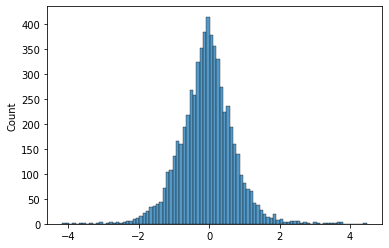

In [9]:
sns.histplot(v.ca1200 - v.jk06)
t_ctr = t[v.ca1200-v.jk06 > 0]
t_wapl = t[v.ca1200-v.jk06 < 0]


In [21]:
######### subset within jet range first of 40kb
D = 40_000
D0 = 20_000_000

D_bool = t.distance<D
D0_bool = t.distance<D0
ctr_bool = (t.ca1200_1 - t.jk06_1) > 0
wapl_bool = (t.ca1200_1 - t.jk06_1) < 0

u_peaks['ctr'] = t.ca1200_1
u_peaks['wapl'] = t.jk06_1
u_peaks['distance'] = t.distance

u_peaks_ctr = u_peaks[np.logical_and(D_bool,ctr_bool)]
u_peaks_wapl = u_peaks[np.logical_and(D_bool,wapl_bool)]

u_peaks_ctr_all = u_peaks[np.logical_and(D0_bool,ctr_bool)]
u_peaks_wapl_all = u_peaks[np.logical_and(D0_bool,wapl_bool)]



print(len(u_peaks_ctr),len(u_peaks_wapl))
#D=40_000: 851,1326
#D=20_000_000: 2902, 3348
print(100*len(u_peaks_ctr)/len(u_peaks_ctr_all), 100*len(u_peaks_wapl)/len(u_peaks_wapl_all), 'percent genes within 40kb jet')
print(len(jets)*80_000 / 100_000_000 * 100)

851 1326
29.32460372157133 39.60573476702509 percent genes within 40kb jet
22.96


In [55]:
np.linspace(0,2,9)

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ])

In [57]:
######### sweep delta 


D = 40_000
D0 = 20_000_000

#delta_lst = [0,0.5,1,1.5,2]
delta_lst = np.linspace(0,2,9)
outperc_ctr = []
outperc_wapl = []

outn_ctr = []
outn_wapl = []


for i in range(len(delta_lst)):
    print(delta_lst[i])
    D_bool = t.distance<D
    D0_bool = t.distance<D0
    ctr_bool = (t.ca1200_1 - t.jk06_1) > delta_lst[i]
    wapl_bool = (t.ca1200_1 - t.jk06_1) < -delta_lst[i]

    u_peaks['ctr'] = t.ca1200_1
    u_peaks['wapl'] = t.jk06_1
    u_peaks['distance'] = t.distance

    u_peaks_ctr = u_peaks[np.logical_and(D_bool,ctr_bool)]
    u_peaks_wapl = u_peaks[np.logical_and(D_bool,wapl_bool)]

    u_peaks_ctr_all = u_peaks[np.logical_and(D0_bool,ctr_bool)]
    u_peaks_wapl_all = u_peaks[np.logical_and(D0_bool,wapl_bool)]
    print(len(u_peaks_ctr_all), len(u_peaks_wapl_all), 'number genes')
    print(len(u_peaks_ctr), len(u_peaks_wapl), 'number genes within 40kb jet')
    print(100*len(u_peaks_ctr)/len(u_peaks_ctr_all), 100*len(u_peaks_wapl)/len(u_peaks_wapl_all), 'percent genes within 40kb jet')
    
    outperc_ctr.append(100*len(u_peaks_ctr)/len(u_peaks_ctr_all))
    outperc_wapl.append(100*len(u_peaks_wapl)/len(u_peaks_wapl_all))
    outn_ctr.append(len(u_peaks_ctr))
    outn_wapl.append(len(u_peaks_wapl))
    
    

0.0
2902 3348 number genes
851 1326 number genes within 40kb jet
29.32460372157133 39.60573476702509 percent genes within 40kb jet
0.25
1941 2360 number genes
643 1065 number genes within 40kb jet
33.127253992787224 45.1271186440678 percent genes within 40kb jet
0.5
1250 1587 number genes
459 837 number genes within 40kb jet
36.72 52.74102079395085 percent genes within 40kb jet
0.75
731 1006 number genes
310 602 number genes within 40kb jet
42.40766073871409 59.84095427435388 percent genes within 40kb jet
1.0
412 593 number genes
200 378 number genes within 40kb jet
48.54368932038835 63.74367622259697 percent genes within 40kb jet
1.25
234 322 number genes
126 225 number genes within 40kb jet
53.84615384615385 69.87577639751552 percent genes within 40kb jet
1.5
137 190 number genes
79 141 number genes within 40kb jet
57.66423357664234 74.21052631578948 percent genes within 40kb jet
1.75
93 102 number genes
60 82 number genes within 40kb jet
64.51612903225806 80.3921568627451 percent ge

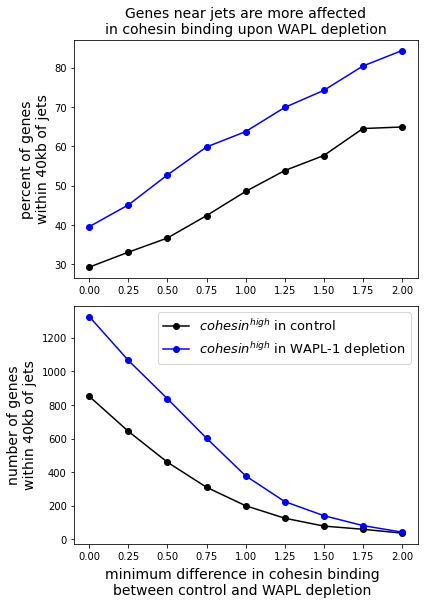

In [67]:
### n peaks, center
f, axs = plt.subplots(
    figsize=(6, 8),
    nrows=2,
    ncols=1,
)
bigFont = 14

Label_1 = '$cohesin^{high}$ in control'
Label_2 = '$cohesin^{high}$ in WAPL-1 depletion'
Labels = [Label_1,Label_2]
Colors = ['black','blue']

ax = axs[0]
ax.plot(delta_lst,outperc_ctr,color=Colors[0],marker = 'o',label=Labels[0])
ax.plot(delta_lst,outperc_wapl,color=Colors[1],marker = 'o',label=Labels[1])
ax.set_ylabel('percent of genes\nwithin 40kb of jets',size=bigFont)


ax = axs[1]
ax.plot(delta_lst,outn_ctr,Colors[0],marker = 'o',label=Labels[0])
ax.plot(delta_lst,outn_wapl,Colors[1],marker = 'o',label=Labels[1])
ax.set_ylabel('number of genes\nwithin 40kb of jets',size=bigFont)


axs[0].set_title('Genes near jets are more affected\nin cohesin binding upon WAPL depletion',size=bigFont)
f.text(0.57, -0.04, 'minimum difference in cohesin binding\nbetween control and WAPL depletion', ha='center',fontsize=bigFont)

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(prop={'size': 13})


plt.tight_layout()

In [68]:
f.savefig('./highlow/Effectsize_vs_proportionGenes_nearJets.pdf',dpi=400,bbox_inches='tight')

In [210]:
print(np.nanmean(u_peaks_ctr.ctr),np.nanmean(u_peaks_ctr.wapl),np.nanmean(u_peaks_ctr.ctr)-np.nanmean(u_peaks_ctr.wapl))
print(np.nanmean(u_peaks_wapl.ctr),np.nanmean(u_peaks_wapl.wapl),np.nanmean(u_peaks_wapl.ctr)-np.nanmean(u_peaks_wapl.wapl))



1.2633167425166554 0.556875142971624 0.7064415995450314
0.16339830781526132 0.9352548615678277 -0.7718565537525663


In [211]:
#u_peaks_ctr.to_csv("./highlow/c_elegans.WS220.annotations_gtf_genes_codingtranscript_controlhigh_values_within40kbjet.bed", sep="\t", quoting=csv.QUOTE_NONE,header=False,index=False)
#u_peaks_wapl.to_csv("./highlow/c_elegans.WS220.annotations_gtf_genes_codingtranscript_waplhigh_values_within40kbjet.bed", sep="\t", quoting=csv.QUOTE_NONE,header=False,index=False)



851
851
1326
1326


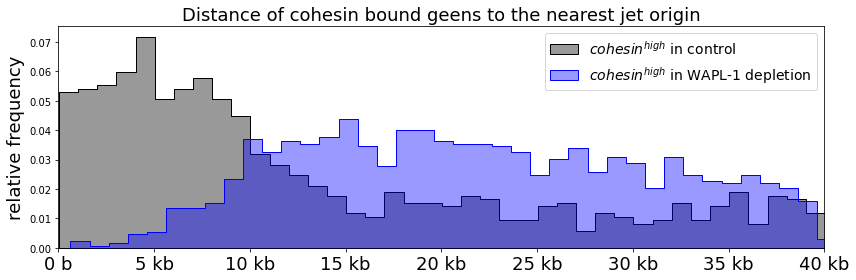

In [216]:
### n peaks, center
f, axs = plt.subplots(
    figsize=(12, 4),
    nrows=1,
    ncols=1,
    sharey='row'
)


Label_1 = '$cohesin^{high}$ in control'
Label_2 = '$cohesin^{high}$ in WAPL-1 depletion'
Labels = [Label_1,Label_2]
Colors = ['black','blue']
D = 40_000

dats = [u_peaks_ctr,u_peaks_wapl]


for i in range(len(dats)):
    print(len(dats[i]))
    vals = dats[i].distance[dats[i].distance<D]
    print(len(vals))
    a = sns.histplot(ax=axs,data = vals, kde = False, label=Labels[i],
                     stat = "probability",color=Colors[i],alpha=0.4,binwidth=1000,element='step')


a.set_title('Distance of cohesin bound geens to the nearest jet origin',fontsize=18)
a.set_xlabel('')
format_ticks(a,x=True,y=False,rotate=False)
plt.xticks(fontsize=18)
a.set_xlim(0,D)

a.legend(prop={'size': 14})
a.set_ylabel('relative frequency' ,rotation=90,fontsize=18,labelpad=4)

#f.text(0.53, -0.03, 'distance between the gene and the nearest jet origin', 
#       ha='center',fontsize=18)

#ax.semilogx()
plt.tight_layout()

In [217]:
f.savefig('./highlow/histogram_distance_genes_highlow_cohesin.pdf',dpi=400,bbox_inches='tight')

